# 제4 고지 : 신경망 만들기 
## STEP 45 : 계층을 모아두는 계층

이전 단계에서는 `Layer` 클래스를 구현하여 매개변수를 자동으로 관리할수 있도록 했다. 하지만 **`Layer` 인스턴스 자체도 관리가 필요**하다. 예를 들어, **10층 신경망을 구현하려 한다면 10개의 `Layer` 인스턴스를 관리**해야 한다. 그래서 이를 해결하기 위해 `Layer` 클래스를 확장한다.

### 45.1 Layer 클래스 확장 

<p align='center'>
    <img src='../assets/그림 45-1.png' align='center' width='80%'>
</p>

`Layer` 클래스는 여러 `Paramter` 를 가질 수 있었다. 여기에 더해서 위의 그림과 같이 **`Layer` 클래스가 다른 `Layer` 도 담을수 있도록 확장**하려 한다.  
이번 단계의 목표는 **바깥 `Layer` 에서 그안에 존재하는 모든 매개변수를 꺼낼 수 있도록 하는 것**이다. 이를 위해 두가지 변화가 필요하다.


1. 인스턴스 변수를 설정할때, `Layer` 인스턴스의 이름도 `_params`에 추가되도록 한다.  
2. `params()` 메서드에서 `obj` 가 `Layer` 라면 **재귀적으로 매개변수**를 꺼내도록 한다. 

```python

class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)): # 1. Layer 도 추가.
            self._params.add(name)
        super().__setattr__(name, value)

    def __call__(self, *inputs):
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs,)
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for y in outputs]
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, inputs):
        raise NotImplementedError()

    def params(self):
        for name in self._params:
            obj = self.__dict__[name]

            if isinstance(obj, Layer): # 2. Layer에서 매개변수 꺼내기
                yield from obj.params() 
            else:
                yield obj

    def cleargrads(self):
        for param in self.params():
            param.cleargrad()
```


In [1]:
import sys
sys.path.append("..")

import numpy as np 
import dezero.functions as F 
import dezero.layers as L
from dezero import Layer

model = Layer()
model.l1=L.Linear(5)
model.l2 =L.Linear(3)

# 추론 수행
def predict(x):
    y= model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y 

# 모든 매개변수에 접근
for p in model.params():
    print(p)
    
# 모든 매개변수의 기울기를 재설정
model.cleargrads()

variable(None)
variable([0. 0. 0. 0. 0.])
variable(None)
variable([0. 0. 0.])


더 나아가 `Layer`클래스를 더 편리하게 사용하는 방법은 다음과 같이 **`Layer`를 상속하여 모델 전체를 하나의 클래스로 정의**하는 방법이다. 

<span style='background-color : #ffdce0'>💡<b>이와 같이 객체지향식 모델정의 방법은 체이너가 최초로 제안했고, 그 후 파이토치,텐서플로우 등 많은 프레임워크에서 보편적으로 사용.</b></span>

```python
class TwoLayerNet(Layer):
    def __init__(self,hidden_size,out_size):
        super().__init__()
        self.l1= L.Linear(hidden_size)
        self.l2=L.Linear(out_size) 
    def forward(self,x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y 
```

### 45.2 Model 클래스
지금까지 자주 등장했던 `Model`은 `사물의 본질을 단순하게 표현한것` 이라는 뜻으로 **머신러닝에서 역시 복잡한 패턴이나 규칙이 숨어 있는 현상을 수식을 이용해서 단순하게 표현**한 것을 말한다.즉, **신경망도 수식으로 표현할 수 있는 함수이며 이를 `Model`**이라 한다.
이제 이를 표현하기 위해 `Model` 클래스를 구현한다. 구체적으로, 

1. `Layer` 를 상속받고,
2. 시각화 메서드 `plot()` 를 추가한다.

```python
from dezero import Layer
from dezero import utils

class Model(Layer):
    def plot(self, *inputs, to_file='model.png'):
        y = self.forward(*inputs)
        return utils.plot_dot_graph(y, verbose=True, to_file=to_file)
```


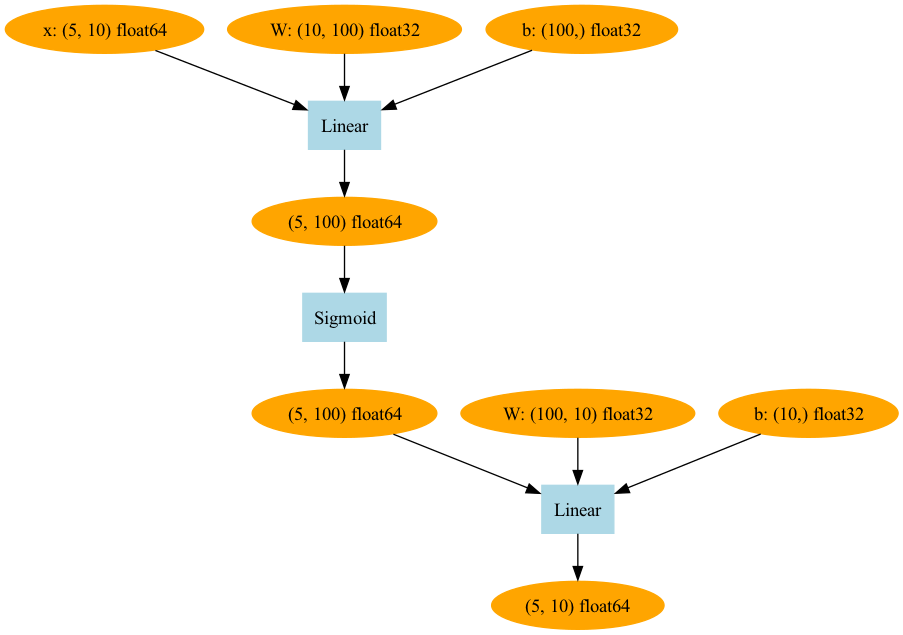

In [2]:
import numpy as np 
import dezero.functions as F 
import dezero.layers as L
from dezero import Variable,Model

class TwoLayerNet(Model):
    def __init__(self,hidden_size,out_size):
        super().__init__()
        self.l1= L.Linear(hidden_size)
        self.l2=L.Linear(out_size) 
    def forward(self,x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y 
    
x = Variable(np.random.rand(5,10),name="x")
model = TwoLayerNet(100,10)
model.plot(x)

### 45.3 Model을 사용한 문제 해결 

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126017)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355146)
variable(0.07655073683421637)
variable(0.07637803086238222)
variable(0.07618764131185564)


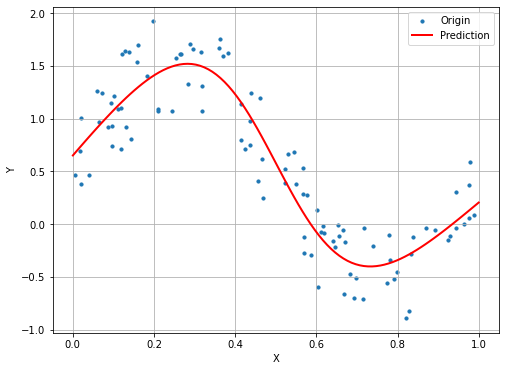

In [4]:
import sys
sys.path.append("..")

import numpy as np 
from dezero import Variable,Model
import dezero.functions as F 
import dezero.layers as L 

# 토이 데이터셋
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 *np.pi *x) + np.random.rand(100,1) #  데이터 생성에 sin 함수 이용




##################################################
# 하이퍼 파라미터
lr = 0.2
iters = 10000
hidden_size=10
# 모델 정의
class TwoLayerNet(Model):
    def __init__(self,hidden_size,out_size):
        super().__init__()
        self.l1= L.Linear(hidden_size)
        self.l2=L.Linear(out_size) 
    def forward(self,x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y 

model = TwoLayerNet(hidden_size,1)
##################################################



# 신경망 학습
for i in range(iters):
    ##################################################
    y_pred = model(x)
    ##################################################
    
    loss = F.mean_squared_error(y,y_pred)
    
    ##################################################
    model.cleargrads()
    ##################################################
    
    loss.backward()

    ##################################################
    for p in model.params():
        p.data -=lr*p.grad.data
    ##################################################
    
    if i % 1000 == 0:
        print(loss)
        
# 그래프로 시각화
import matplotlib.pyplot as plt
x_test = np.linspace(0, 1, 100).reshape(100,1)

y_pred = model(x_test)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Origin', s=10)
plt.plot(x_test, y_pred.data, label='Prediction', color='red', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

### 45.4 MLP 클래스

앞서 하나의 클래스로 2층신경망을 구현했다. 이번에는 더 범용적인 **완전연결계층 신경망(MLP,Multi-Layer Perceptron)** 을 구현해본다.

In [15]:
import dezero.functions as F 
import dezero.layers as L 
class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):
        # fc : fully connected
        super().__init__()
        self.activation = activation
        self.layers = []

        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer) # model.l0 ~ model.l{len(fc_output_sizes)-1}
            self.layers.append(layer)

    def forward(self, x): 
        for l in self.layers[:-1]: #  마지막 layer전까지 활성화 함수를 통한 비선형 변환
            x = self.activation(l(x))
        return self.layers[-1](x) # 마지막 아웃풋

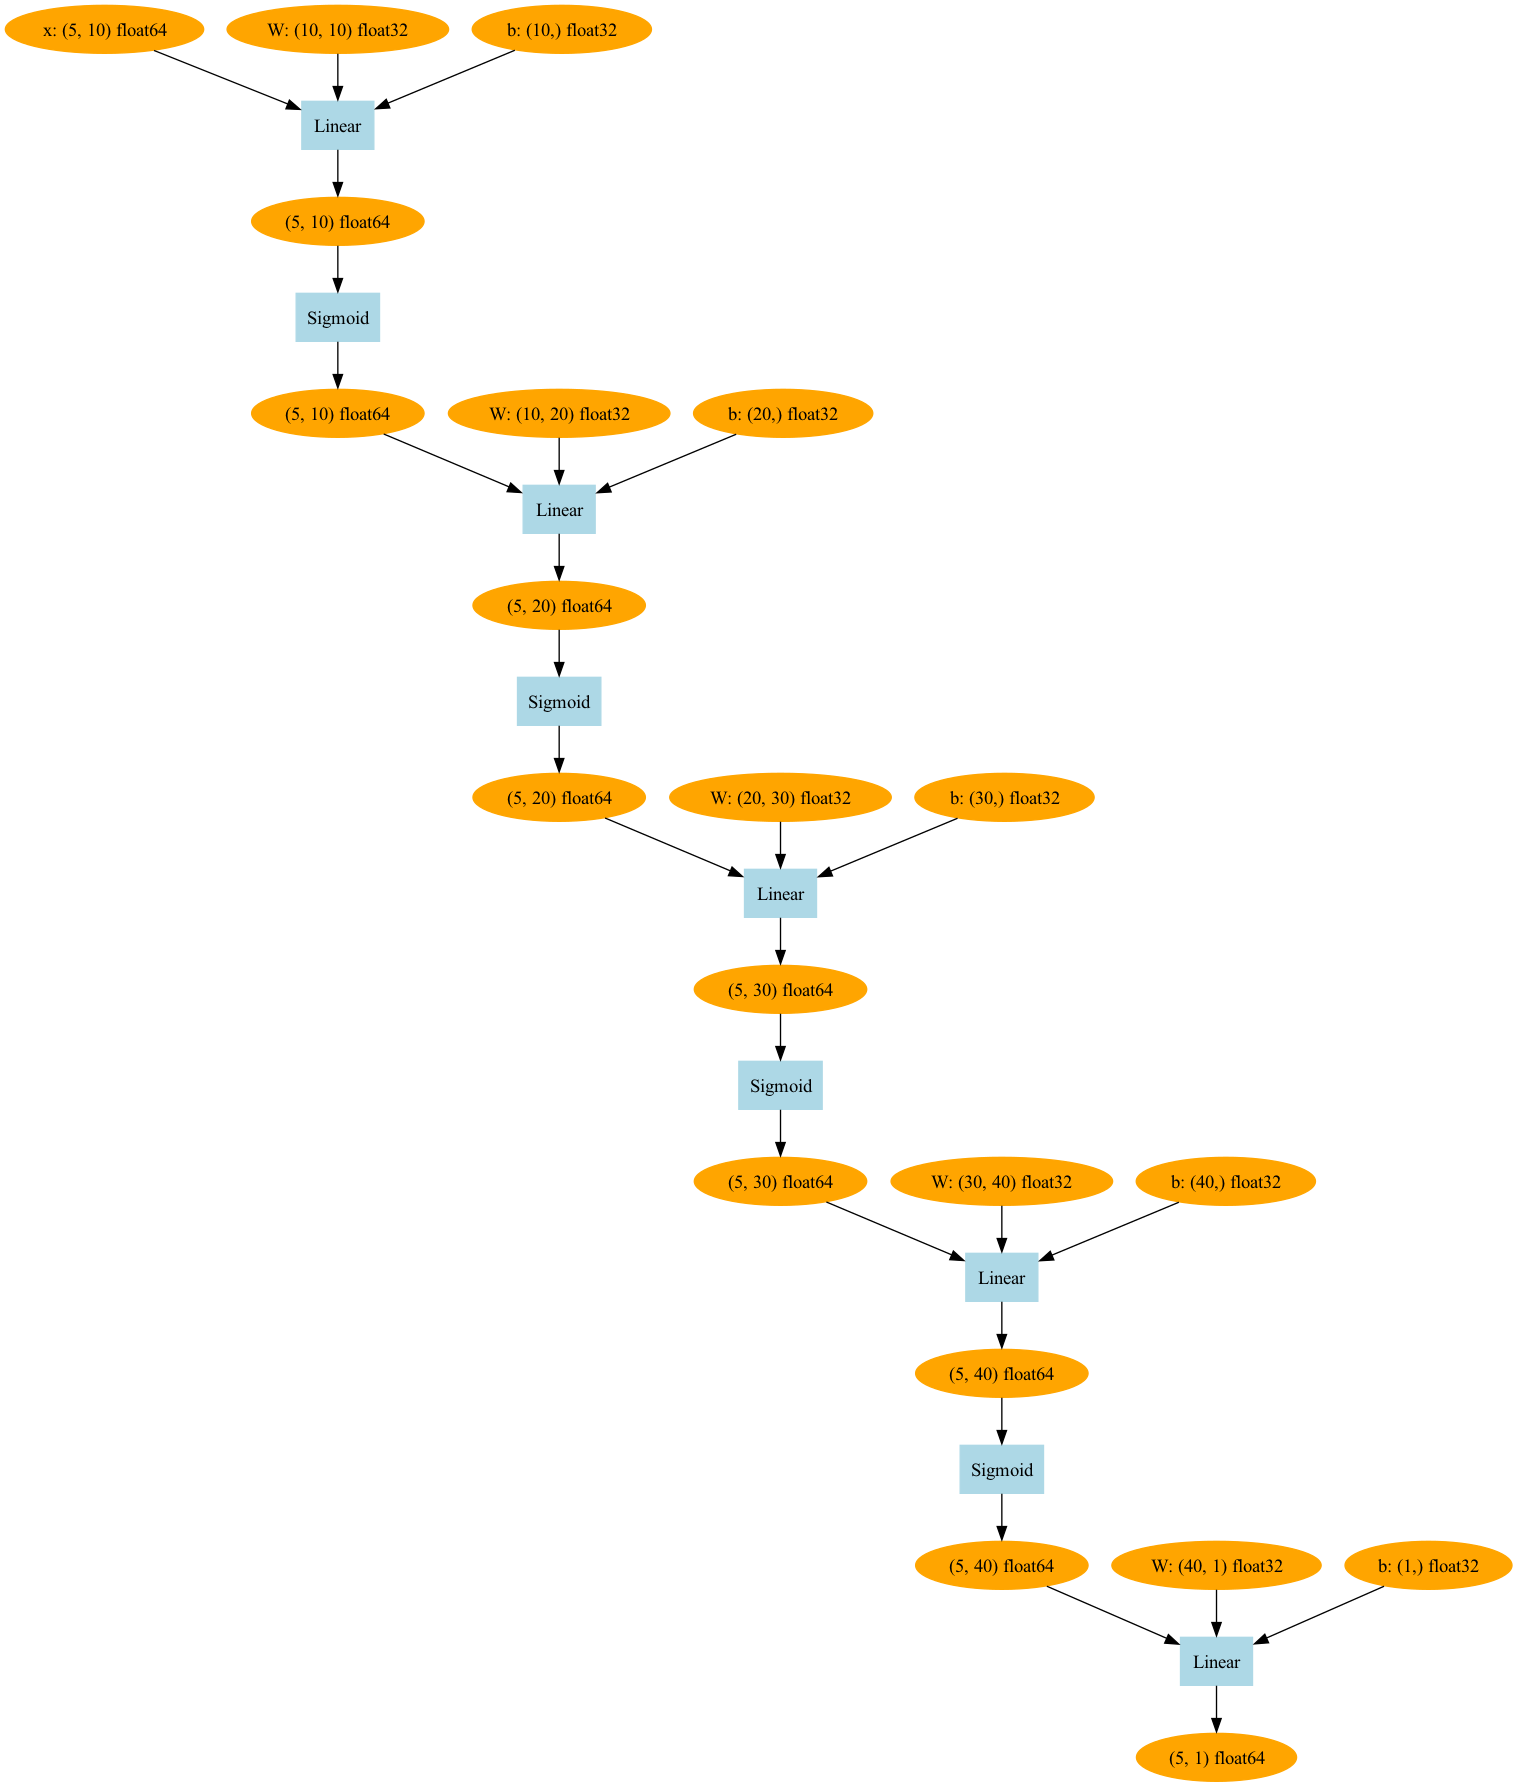

In [16]:
x = Variable(np.random.rand(5,10),name="x")
model = MLP((10,1)) # 1층 
model = MLP((10,20,30,40,1)) # 5층 
model.plot(x)
# model.l0 ~ model.l4